In [1]:
import os 
import pandas as pd
import numpy as np
import glob
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebookº
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Carga de información

In [2]:
laliga2122 = pd.read_excel('datos_liga/LaLiga21 22.xlsx', )
laliga2021 = pd.read_excel('datos_liga/LaLiga20 21.xlsx', )
laliga1920 = pd.read_excel('datos_liga/LaLiga19 20.xlsx', )
laliga1819 = pd.read_excel('datos_liga/LaLiga18 19.xlsx', )
laliga1718 = pd.read_excel('datos_liga/LaLiga17 18.xlsx', )
laliga1617 = pd.read_excel('datos_liga/LaLiga16 17.xlsx', )
seg2122 =  pd.read_excel('datos_liga/LaLiga123 21 22.xlsx', )
seg2021 =  pd.read_excel('datos_liga/LaLiga123 20 21.xlsx', )
seg1920 =  pd.read_excel('datos_liga/LaLiga123 19 20.xlsx', )
seg1819 =  pd.read_excel('datos_liga/LaLiga123 18 19.xlsx', )
seg1718 =  pd.read_excel('datos_liga/LaLiga123 17 18.xlsx', )
seg1617 =  pd.read_excel('datos_liga/LaLiga123 16 17.xlsx', )

In [3]:
laliga = laliga2122.dropna(how='all').append(laliga2021.dropna(how='all')
).append(laliga1920.dropna(how='all')).append(laliga1819.dropna(how='all')
).append(laliga1718.dropna(how='all')).append(laliga1617.dropna(how='all')).loc[:,
['Wk','Date','Local','xG','Score','xG.1','Visitante', 'Attendance']]
laliga['Attendance']= laliga['Attendance']*1000

In [4]:
def total_goles(string):
    goles = string.split('–')
    total_goles = int(goles[0])+int(goles[1])
    return total_goles
laliga['Total de goles']= laliga['Score'].apply(total_goles)

In [5]:
def torneo(año,mes):
    if ((año==2016) & (mes<=12)|(año==2017) & (mes<8)):
        return '16/17'
    elif ((año==2017) & (mes<=12)|(año==2018) & (mes<8)):
        return '17/18'
    elif ((año==2018) & (mes<=12)|(año==2019) & (mes<8)):
        return '18/19'
    elif ((año==2019) & (mes<=12)|(año==2020) & (mes<9)):
        return '19/20'
    elif ((año==2020) & (mes<=12)|(año==2021) & (mes<8)):
        return '20/21'
    elif ((año==2021) & (mes<=12)|(año==2022) & (mes<8)):
        return '21/22'

    
laliga['Año'] = laliga['Date'].dt.year
laliga['Mes'] = laliga['Date'].dt.month
laliga['Temporada'] = laliga.apply(lambda x: torneo(x['Año'],x['Mes']),axis = 1)

## Análisis de victorias

Crearemos columnas para analizar los resultados de los partidos de cada torneo. Primero, una columna que nos diga si ganó el equipo local o visitante y otra columna con el nombre del equipo que ganó

In [6]:
def golesvisita(marcador):
    goles = marcador.split('–')
    return int(goles[1])

def goleslocal(marcador):
    goles = marcador.split('–')
    return int(goles[0])

laliga['Goles Local'] = laliga['Score'].apply(goleslocal)
laliga['Goles Visitante'] = laliga['Score'].apply(golesvisita)

In [7]:
def resultado(string):
    goles = string.split('–')
    if int(goles[0])>int(goles[1]):
        return 'Local'
    if int(goles[0])<int(goles[1]):
        return 'Visitante'
    else: 
        return 'Empate'
    
def resultado_equipo(string, local, visita):
    goles = string.split('–')
    if int(goles[0])>int(goles[1]):
        return local
    if int(goles[0])<int(goles[1]):
        return visita
    else: 
        return 'Empate'
laliga['Resultado'] = laliga['Score'].apply(resultado)
laliga['Ganador'] = laliga.apply(lambda x: resultado_equipo(x['Score'],x['Local'],x['Visitante']),axis=1)

Ahora, podemos estudiar la cantidad de partidos que ganó el equipo local, visita o fue empate por cada torneo.


In [8]:
condicion_predominante = laliga.groupby(['Temporada','Resultado'])['Wk'].count().reset_index()
condicion_predominante = condicion_predominante.set_axis(
['Temporada', 'Resultado','Cantidad'], axis='columns')

condicion_predominante

,Temporada,Resultado,Cantidad
0,16/17,Empate,89
1,16/17,Local,181
2,16/17,Visitante,110
3,17/18,Empate,86
4,17/18,Local,179
5,17/18,Visitante,115
6,18/19,Empate,110
7,18/19,Local,168
8,18/19,Visitante,102
9,19/20,Empate,105


Si solo nos interesa el histórico, sin considerar la diferencia por temporada, tenemos que :

In [11]:
cond_predominante_abs = laliga.groupby(['Resultado'])['Wk'].count().reset_index()
cond_predominante_abs = cond_predominante_abs.set_axis(
['Resultado','Cantidad'], axis='columns')

cond_predominante_abs

,Resultado,Cantidad
0,Empate,610
1,Local,1025
2,Visitante,645


In [12]:
fig1 = px.pie(cond_predominante_abs, values ='Cantidad', names ='Resultado', title='La Liga 2016-2022',
        color = 'Resultado', color_discrete_map={'Local':'royalblue', 'Visitante':'orangered',
        'Empate':'lightgreen'})

fig1.update_traces(textposition='inside', textinfo='percent+value')
fig1.show()

De donde se puede notar una clara tendencia a la victoria del equipo local.

## Más ganadores
Ahora, nos puede interesar saber los equipos que más han ganado durante las últimas 6 temporadas de la liga española.

In [13]:
mas_ganadores = laliga[laliga['Ganador']!= 'Empate'].groupby(['Ganador'])['Wk'].count().reset_index()
mas_ganadores = mas_ganadores.set_axis(['Equipo','Cantidad de victorias'], axis='columns')
mas_ganadores = mas_ganadores.sort_values(by= 'Cantidad de victorias', ascending = False)
mas_ganadores.head(3)

,Equipo,Cantidad de victorias
3,Barcelona,152
22,Real Madrid,149
2,Atlético Madrid,133


In [14]:

fig2 = px.pie(mas_ganadores, values = 'Cantidad de victorias', names = 'Equipo', title = "La Liga Result from 2016-2022 - Most Win Team",
    color = 'Equipo', color_discrete_sequence= px.colors.qualitative.Light24)
fig2.update_traces(textposition='inside', textinfo='percent+label')
fig2.show()

## Cantidad de partidos con x goles por torneo 

También, nos puede interesar la cantidad de goles que se han realizado en un torneo:

In [15]:
def intervalos(score):
    goles = score.split('–')
    total_goles = int(goles[0])+int(goles[1])
    if total_goles <1:
        return '0'
    elif total_goles<2:
        return '1'
    elif total_goles<3:
        return '2'
    elif total_goles<4:
        return '3'
    elif total_goles>=4:
        return '4+'
laliga['Clasificación goles'] = laliga['Score'].apply(intervalos)

In [16]:
cant_goles_pp = laliga.groupby(['Temporada','Clasificación goles'])['Date'].count().reset_index()
cant_goles_pp = cant_goles_pp.set_axis(['Temporada','Cantidad de goles por partido','Cantidad de partidos'],
                axis= 'columns')
cant_goles_pp.head(10)

,Temporada,Cantidad de goles por partido,Cantidad de partidos
0,16/17,0,27
1,16/17,1,57
2,16/17,2,82
3,16/17,3,86
4,16/17,4+,128
5,17/18,0,28
6,17/18,1,82
7,17/18,2,78
8,17/18,3,84
9,17/18,4+,108


## Visualización de la asistencia de público


In [17]:
total_asist =laliga.groupby('Temporada')['Attendance'].agg('sum').reset_index()
fig2 = px.line(total_asist, x = 'Temporada', y = 'Attendance', 
title = 'Asistencia total por temporada de La Liga entre 2016-2022', line_shape = 'spline')
fig2.show()


Se puede observar como afecto la pandemia a la asistencia de público durante los años 2020 y 2021. Recordemos que la temporada 19/20 se vio afectada en la recta final (finales de febrero, principio de marzo) y la temporada 20/21 prácticamente completa.

## Visualización goles con gráfico de barras

Ahora, si queremos analizar los goles realizados por cada equipo en ambas condiciones, es decir, local y visita, podemos graficarlo en un gráfico de barras:

In [18]:
test1 = laliga.groupby('Local')['Goles Local'].agg('sum').reset_index()
test1 = test1.rename(columns={"Local": "Equipo", 'Goles Local': 'Total de goles históricos de Local'})

test2 = laliga.groupby('Visitante')['Goles Visitante'].agg('sum').reset_index()
test2 = test2.rename(columns = {'Goles Visitante': 'Total de goles históricos de Visitante'})

result = pd.concat([test1, test2], axis=1)
dt = result.drop(['Visitante'], axis=1)

fig3 = px.bar(dt, x = "Equipo", y =['Total de goles históricos de Local','Total de goles históricos de Visitante'],
    title = 'Total de goles desde 2016-2022 Equipos de LaLiga')
fig3.show()

Los últimos 6 campeonatos se han repartido los 3 primeros lugares entre Real Madrid, Barcelona y Atlético Madrid. El Real Madrid se ha consagrado campeón en 3 oportunidades, Barcelona 2 y At Madrid 1. Llama la atención que Villarreal y Sevilla tengan una cantidad de goles similares al Atlético de Madrid a pesar de no haber estado en el podio de ninguno de estos torneos

Ejemplo con matplotlib: 

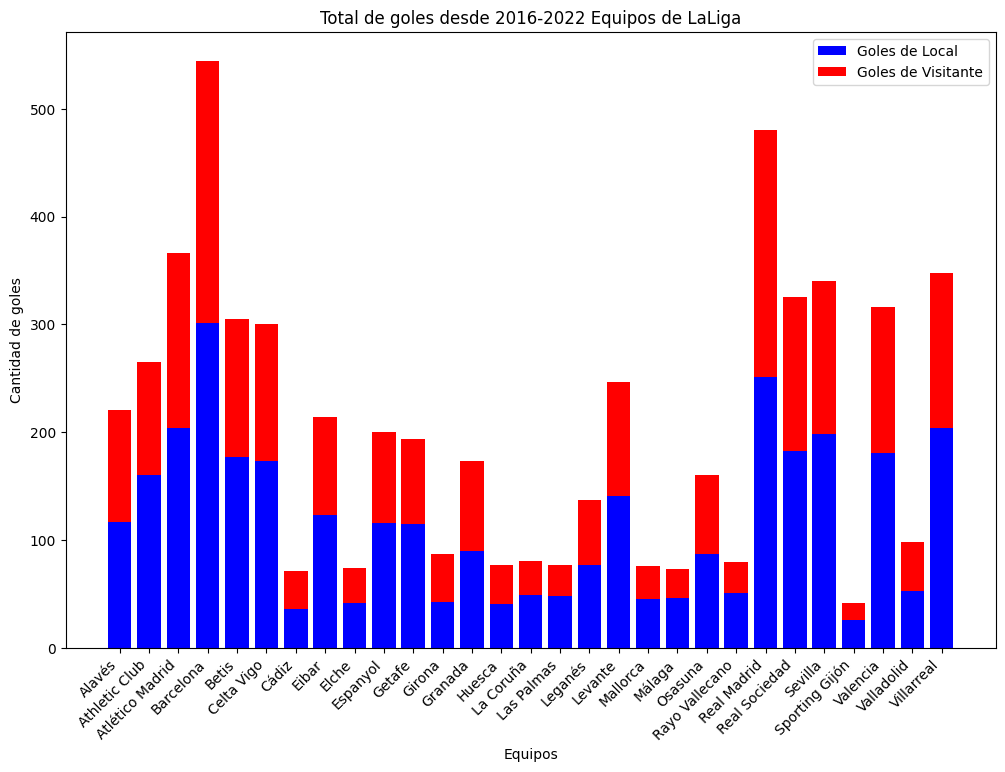

In [19]:
fig, ax = plt.subplots(figsize = (12,8))

x=dt['Equipo']
label2="Goles de Visitante"
label1="Goles de Local"
y1= dt['Total de goles históricos de Local']
y2= dt['Total de goles históricos de Visitante']

plt.bar(x=x, height=y1, label=label1, color="blue")
plt.bar(x=x, height=y2,bottom=y1 ,label= label2, color="red")
plt.xticks(rotation=45, ha="right")


plt.title("Total de goles desde 2016-2022 Equipos de LaLiga")
plt.xlabel("Equipos")
plt.ylabel("Cantidad de goles")
plt.legend()

plt.show()

## Pregunta formativa 1
¿Cómo es el código que construye un Dataframe de asistencia total por equipo durante las 6 temporadas?

In [20]:
total_asist_equipo =laliga.groupby('Local')['Attendance'].agg('sum').reset_index()
total_asist_equipo = total_asist_equipo.rename(columns={'Local':'Equipo'})
total_asist_equipo = total_asist_equipo.sort_values(by= 'Attendance', ascending = False)

total_asist_equipo

,Equipo,Attendance
3,Barcelona,6272438.0
22,Real Madrid,5452011.0
2,Atlético Madrid,4834556.0
4,Betis,3847810.0
1,Athletic Club,3417075.0
26,Valencia,3213405.0
24,Sevilla,2974514.0
23,Real Sociedad,2120247.0
9,Espanyol,1735163.0
0,Alavés,1470820.0


## Pregunta formativa 2

In [21]:
test1 = laliga.groupby('Local')['Goles Local'].agg('sum').reset_index()
test1 = test1.rename(columns={"Local": "Equipo", 'Goles Local': 'Total de goles históricos de Local'})

test2 = laliga.groupby('Visitante')['Goles Visitante'].agg('sum').reset_index()
test2 = test2.rename(columns = {'Goles Visitante': 'Total de goles históricos de Visitante'})

result = pd.concat([test1, test2], axis=1)
dt = result.drop(['Visitante'], axis=1)
dt['Total goles histórico'] = dt['Total de goles históricos de Local'] +dt['Total de goles históricos de Visitante'] 


In [22]:
dff2 = dt.loc[:,['Equipo','Total goles histórico']]
dff2

,Equipo,Total goles histórico
0,Alavés,221
1,Athletic Club,265
2,Atlético Madrid,366
3,Barcelona,544
4,Betis,305
5,Celta Vigo,300
6,Cádiz,71
7,Eibar,214
8,Elche,74
9,Espanyol,200


In [25]:
figPF4 = px.pie(dff2, values = 'Total goles histórico', names = 'Equipo', title = "Total de Goles en La Liga 2016-2022", color = 'Equipo', color_discrete_sequence= px.colors.qualitative.Light24)
figPF4.update_traces(textposition='inside', textinfo='percent+label')
figPF4.show()